# Creating the graph

In [1]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import pickle
import numpy as np

# ---------------------
# 1. Load the dataset
# ---------------------
path = "routes_master_data.csv"
key_features = [
    'Route_Name',
    'Order',
    'StopPlace Name',
    'StopPlace Latitude',
    'StopPlace Longitude',
    'Journey_ID',
    'TransportMode',
    'ArrivalTime',
    'DepartureTime'
]
df = pd.read_csv(path, usecols=key_features)

# -----------------------------------------
# 2. Helper function to convert to seconds
# -----------------------------------------
def to_seconds(time_str):
    if pd.isna(time_str) or time_str is None:
        return None
    time_obj = datetime.strptime(time_str, "%H:%M:%S")
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second

# ---------------------
# 3. Create node graph
# ---------------------
graph = {}
for _, row in tqdm(df.iterrows(), total=len(df), desc="Creating nodes"):
    stop_id = row['StopPlace Name']
    if stop_id not in graph:
        graph[stop_id] = {
            'latitude': row['StopPlace Latitude'],
            'longitude': row['StopPlace Longitude'],
            'neighbors': {}  # Will be filled
        }

# --------------------------------------------------------------------
# 4. Group by route, journey, mode. Sort by 'Order' but don't require
#    next_stop['Order'] == current_stop['Order'] + 1
# --------------------------------------------------------------------
grouped = df.groupby(['Route_Name', 'Journey_ID', 'TransportMode'])

travel_time_records = {}
for (route_name, journey_id, mode), group_data in tqdm(grouped, desc="Building edges"):
    # Sort by 'Order'
    group_data = group_data.sort_values(by='Order').reset_index(drop=True)
    
    for i in range(len(group_data) - 1):
        current_stop = group_data.iloc[i]
        next_stop    = group_data.iloc[i+1]
        
        current_id = current_stop['StopPlace Name']
        next_id    = next_stop['StopPlace Name']

        # If you still want to skip any large leaps, you can condition on
        # the difference, but typically you'd just do consecutive rows here.
        
        departure_time = current_stop['DepartureTime']
        arrival_time   = next_stop['ArrivalTime']
        
        t1 = to_seconds(departure_time)
        t2 = to_seconds(arrival_time)
        
        if t1 is not None and t2 is not None:
            # Handle midnight crossing
            if t2 < t1:
                t2 += 86400  # 24 hours in seconds
                
            travel_time = abs(t2 - t1)
            
            if current_id != next_id:
                # Keep track of the times observed
                key = (current_id, next_id, mode)
                if key not in travel_time_records:
                    travel_time_records[key] = []
                travel_time_records[key].append(travel_time)

# ---------------------------------------------------
# 5. Compute mean travel time and store in the graph
# ---------------------------------------------------
for (current_id, next_id, mode), times in travel_time_records.items():
    mean_travel_time = np.mean(times)
    if next_id not in graph[current_id]['neighbors']:
        graph[current_id]['neighbors'][next_id] = {}
    # Optionally store a single record or a list. We'll just store one for simplicity:
    graph[current_id]['neighbors'][next_id][mode] = mean_travel_time

# ----------------------
# 6. Save the final graph
# ----------------------
with open('graph_with_relaxed_order.pickle', 'wb') as f:
    pickle.dump(graph, f)

print("Graph successfully updated to allow for non-sequential Order values.")

Building edges: 100%|█████████▉| 38278/38280 [00:48<00:00, 795.63it/s] 


Graph successfully updated to allow for non-sequential Order values.


# Assigning scenic values

In [3]:
with open('graph_with_relaxed_order.pickle', 'rb') as file:
    graph = pickle.load(file)

# Mapping the scenic values to each stops and its corresponding neighbors
with open('stop_scenic_values.json', 'r') as file:
    stop_scenic_values = json.load(file) # [{'Campus Roslagen': 6.5}, {'Stockholmsvägen': 6.5}, ...]
    
scenic_values_dict = {}
for scenic_value in stop_scenic_values:
    for stop, value in scenic_value.items():
        scenic_values_dict[stop] = value

for stop, info in graph.items():
    if stop in scenic_values_dict:
        info['scenic_value'] = scenic_values_dict[stop]
    for neighbor, neighbor_info in info.get('neighbors', {}).items():
        if neighbor in scenic_values_dict:
            neighbor_info['scenic_value'] = scenic_values_dict[neighbor]

with open('graph_with_scenic_values.pickle', 'wb') as file:
    pickle.dump(graph, file)

# A star

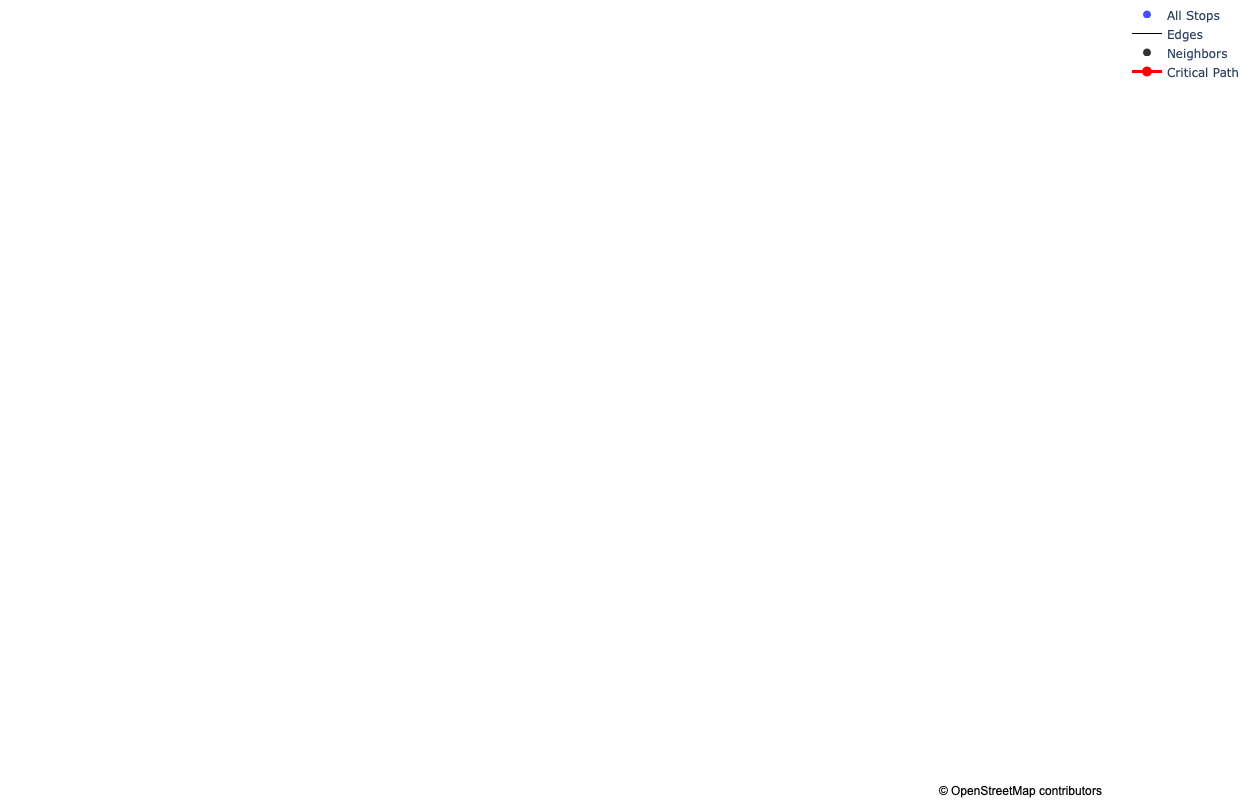

average_scenic_value = 8.25
cumulative_travel_time = 11.94 min


,From,To,Transport Mode,Travel Time (seconds),Current Stop Scenic Value,Next Stop Scenic Value
0,Ropsten,Gärdet,metro,120.00,6.5,7.5
1,Gärdet,Karlaplan,metro,105.00,7.5,6.5
2,Karlaplan,Östermalmstorg,metro,121.83,6.5,7.5
3,Östermalmstorg,T-Centralen,metro,150.00,7.5,6.5
4,T-Centralen,Kungsträdgården,bus,115.72,6.5,8.5
5,Kungsträdgården,Nybroplan,bus,103.76,8.5,6.5


In [78]:
import heapq
import plotly.graph_objects as go
import numpy as np
import pickle

def scenic_cost(scenic_value, C=10, lam=2):
    return C * np.exp(-lam * (scenic_value - 10))

def a_star_search(graph, start, goal):
    transport_mode_scenic_factors = {
        'bus':   1.0,
        'metro': 1.0,
        'water': 1.0,
        'tram':  1.0,
        'rail':  1.0
    }

    open_list = []
    heapq.heappush(open_list, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while open_list:
        current_cost, current_stop = heapq.heappop(open_list)

        if current_stop == goal:
            break

        for neighbor_stop, neighbor_info in graph[current_stop]['neighbors'].items():
            neighbor_scenic_value = neighbor_info.get('scenic_value')
            modes = [(m, t) for m, t in neighbor_info.items() if m != 'scenic_value']

            for (transport_mode, travel_time) in modes:
                scenic_factor = transport_mode_scenic_factors.get(transport_mode)
                current_scenic_value = graph[current_stop].get('scenic_value')
                avg_scenic_value = (current_scenic_value + neighbor_scenic_value) / 2.0
                effective_scenic_value = scenic_factor * avg_scenic_value
                new_cost = cost_so_far[current_stop] + travel_time + scenic_cost(effective_scenic_value)

                if neighbor_stop not in cost_so_far or new_cost < cost_so_far[neighbor_stop]:
                    cost_so_far[neighbor_stop] = new_cost
                    heuristic = 0  # or your chosen heuristic
                    priority = new_cost + heuristic
                    heapq.heappush(open_list, (priority, neighbor_stop))
                    came_from[neighbor_stop] = current_stop

    path = []
    current_stop = goal
    while current_stop is not None:
        path.append(current_stop)
        current_stop = came_from.get(current_stop)
    path.reverse()

    return path

# Example Usage
with open('graph_with_scenic_values.pickle', 'rb') as file:
    graph = pickle.load(file)

start_stop = 'Ropsten'
goal_stop = 'Nybroplan'
shortest_path = a_star_search(graph, start_stop, goal_stop)

travel_data = []
for i in range(len(shortest_path) - 1):
    current_stop = shortest_path[i]
    next_stop = shortest_path[i + 1]

    # Grab the neighbor info, e.g. {'bus': 241.0, 'scenic_value': 6.5}
    neighbor_info = graph[current_stop]['neighbors'][next_stop]
    
    # Filter out 'scenic_value' to get (transport_mode, travel_time) pairs
    # For example, mode_time_pairs might be [('bus', 241.0)].
    mode_time_pairs = [
        (mode, travel_time) 
        for mode, travel_time in neighbor_info.items() 
        if mode != 'scenic_value'
    ]

    # If there's exactly one mode, just use that. If there are multiple, pick or loop.
    if len(mode_time_pairs) > 0:
        transport_mode, travel_time = mode_time_pairs[0]
    else:
        # Edge case: no mode found
        transport_mode = None
        travel_time = None

    # Get the scenic values from the graph
    current_scenic_value = graph[current_stop].get('scenic_value')
    next_scenic_value = graph[next_stop].get('scenic_value')

    travel_data.append({
        "From": current_stop,
        "To": next_stop,
        "Transport Mode": transport_mode,
        "Travel Time (seconds)": round(travel_time, 2) if travel_time else None,
        "Current Stop Scenic Value": current_scenic_value,
        "Next Stop Scenic Value": next_scenic_value
    })

travel_df = pd.DataFrame(travel_data)

def visualize_path(graph, path):
    # Extract all stops' data
    all_longitudes = [graph[stop]['longitude'] for stop in graph]
    all_latitudes = [graph[stop]['latitude'] for stop in graph]
    all_stop_names = list(graph.keys())
    all_scenic_values = [graph[stop].get('scenic_value', 0) for stop in graph]

    # Extract edges and neighbors for path vertices and their neighbors
    edges_latitudes = []
    edges_longitudes = []
    edges_hovertext = []
    neighbor_latitudes = []
    neighbor_longitudes = []
    neighbor_hovertext = []

    for stop in path:
        if 'neighbors' in graph[stop]:
            for neighbor, edge_data in graph[stop]['neighbors'].items():
                # Add edges from path to neighbors
                edges_latitudes.extend([graph[stop]['latitude'], graph[neighbor]['latitude'], None])
                edges_longitudes.extend([graph[stop]['longitude'], graph[neighbor]['longitude'], None])
                transportation_mode = edge_data.get('transportation_mode', 'Unknown')
                edges_hovertext.append(
                    f"Edge: {stop} to {neighbor}<br>Transportation Mode: {transportation_mode}"
                )

                # Add neighbors to markers
                neighbor_latitudes.append(graph[neighbor]['latitude'])
                neighbor_longitudes.append(graph[neighbor]['longitude'])
                neighbor_hovertext.append(
                    f"Stop: {neighbor}<br>Scenic Value: {graph[neighbor].get('scenic_value', 0)}"
                )

                # Add edges and markers for neighbors' neighbors
                if 'neighbors' in graph[neighbor]:
                    for second_neighbor, second_edge_data in graph[neighbor]['neighbors'].items():
                        edges_latitudes.extend([graph[neighbor]['latitude'], graph[second_neighbor]['latitude'], None])
                        edges_longitudes.extend([graph[neighbor]['longitude'], graph[second_neighbor]['longitude'], None])
                        second_transportation_mode = second_edge_data.get('transportation_mode', 'Unknown')
                        edges_hovertext.append(
                            f"Edge: {neighbor} to {second_neighbor}<br>Transportation Mode: {second_transportation_mode}"
                        )
                        neighbor_latitudes.append(graph[second_neighbor]['latitude'])
                        neighbor_longitudes.append(graph[second_neighbor]['longitude'])
                        neighbor_hovertext.append(
                            f"Stop: {second_neighbor}<br>Scenic Value: {graph[second_neighbor].get('scenic_value', 0)}"
                        )

    # Extract the longitude, latitude, and scenic values of stops in the critical path
    path_longitudes = [graph[stop]['longitude'] for stop in path]
    path_latitudes = [graph[stop]['latitude'] for stop in path]
    path_scenic_values = [graph[stop].get('scenic_value') for stop in path]
    path_stop_names = path

    # Calculate the average of the start and end stop coordinates for centering the map
    start_longitude = graph[path[0]]['longitude']
    start_latitude = graph[path[0]]['latitude']
    end_longitude = graph[path[-1]]['longitude']
    end_latitude = graph[path[-1]]['latitude']
    avg_longitude = (start_longitude + end_longitude) / 2
    avg_latitude = (start_latitude + end_latitude) / 2

    # Create a Plotly figure
    fig = go.Figure()

    # Add all stops as markers
    fig.add_trace(go.Scattermapbox(
        lat=all_latitudes,
        lon=all_longitudes,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='blue',  # Color for all stops
            opacity=0.7
        ),
        hoverinfo='text',
        hovertext=[f'Stop: {stop_name}<br>Scenic Value: {scenic_value}' 
                   for stop_name, scenic_value in zip(all_stop_names, all_scenic_values)],
        name='All Stops'
    ))

    # Add edges between path vertices, their neighbors, and neighbors' neighbors
    fig.add_trace(go.Scattermapbox(
        lat=edges_latitudes,
        lon=edges_longitudes,
        mode='lines',
        line=go.scattermapbox.Line(
            color='black',
            width=1
        ),
        hoverinfo='text',
        hovertext=edges_hovertext,
        name='Edges'
    ))

    # Add neighbors and their neighbors as black markers
    fig.add_trace(go.Scattermapbox(
        lat=neighbor_latitudes,
        lon=neighbor_longitudes,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='black',  # Color for neighbors
            opacity=0.8
        ),
        hoverinfo='text',
        hovertext=neighbor_hovertext,
        name='Neighbors'
    ))

    # Add critical path as a line with highlighted markers
    fig.add_trace(go.Scattermapbox(
        lat=path_latitudes,
        lon=path_longitudes,
        mode='markers+lines',
        marker=go.scattermapbox.Marker(
            size=10,
            color='red',  # Color for critical path stops
            opacity=1.0
        ),
        line=go.scattermapbox.Line(
            color='red',  # Line color for critical path
            width=3
        ),
        hoverinfo='text',
        hovertext=[f'Stop: {stop_name}<br>Scenic Value: {scenic_value}' 
                   for stop_name, scenic_value in zip(path_stop_names, path_scenic_values)],
        name='Critical Path'
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=10,
        mapbox_center_lat=avg_latitude,
        mapbox_center_lon=avg_longitude,
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        height=800
    )
    fig.show()

visualize_path(graph, shortest_path) # Plots the map

# Shows some statistics
average_scenic_value = (travel_df["Current Stop Scenic Value"].sum() + travel_df["Next Stop Scenic Value"].iloc[-1]) / len(travel_df)
cumulative_travel_time = travel_df["Travel Time (seconds)"].sum() / 60
print(f"{average_scenic_value = :.2f}")
print(f"{cumulative_travel_time = :.2f} min")
travel_df